In [92]:
import skforecast
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-darkgrid')
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from dateutil.relativedelta import relativedelta

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.model_selection import backtesting_forecaster
from skforecast.model_selection import grid_search_forecaster

In [93]:
df = pd.read_csv('database/DIM_PLAYER_GAMES.csv')
data = df.loc[df['PLAYER']=='Christian McCaffrey']
data['FORECAST_DATE'] = pd.date_range("2018-01-01", periods=len(data), freq="MS")
data['FORECAST_DATE'] = pd.to_datetime(data['FORECAST_DATE'], format='%Y-%m-%d')
data = data.set_index('FORECAST_DATE')
data = data.asfreq('MS')
data = data['PPR']
data.sort_index()


C:\Users\012356.CORPORATE\AppData\Local\Temp\ipykernel_28980\329181882.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['FORECAST_DATE'] = pd.date_range("2018-01-01", periods=len(data), freq="MS")
C:\Users\012356.CORPORATE\AppData\Local\Temp\ipykernel_28980\329181882.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['FORECAST_DATE'] = pd.to_datetime(data['FORECAST_DATE'], format='%Y-%m-%d')


FORECAST_DATE
2018-01-01    15.5
2018-02-01    27.9
2018-03-01    21.4
2018-04-01    20.3
2018-05-01    13.6
              ... 
2023-06-01    29.8
2023-07-01    20.2
2023-08-01    21.3
2023-09-01    30.9
2023-10-01    22.3
Freq: MS, Name: PPR, Length: 70, dtype: float64

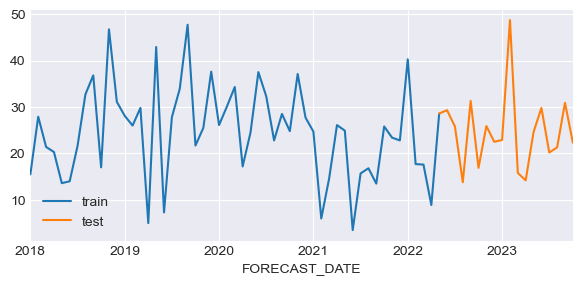

In [94]:
end_train = max(data.index) - relativedelta(months=17)
fig, ax = plt.subplots(figsize=(7, 3))
data.loc[:end_train].plot(ax=ax, label='train')
data.loc[end_train:].plot(ax=ax, label='test')
ax.legend()

In [95]:
forecaster = ForecasterAutoreg(
                 regressor = RandomForestRegressor(random_state=123),
                 lags      = 3
             )

forecaster.fit(y=data.loc[:max(data.index) - relativedelta(months=18)])
forecaster

ForecasterAutoreg 
Regressor: RandomForestRegressor(random_state=123) 
Lags: [1 2 3] 
Transformer for y: None 
Transformer for exog: None 
Window size: 3 
Weight function included: False 
Differentiation order: None 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('2018-01-01 00:00:00'), Timestamp('2022-04-01 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: MS 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0, 'warm_start': False} 
fit_kwargs: {} 
Creation date: 2023-12-10 21:43:13 
Last fit date: 2023-12-10 21:43:13 
Skforecast version: 0.11.0 
Python version: 3.11.3

In [96]:
predictions = forecaster.predict(steps=len(data.loc[end_train:]))
predictions.tail(3)

2023-08-01    25.6590
2023-09-01    18.7902
2023-10-01    17.4348
Freq: MS, Name: pred, dtype: float64

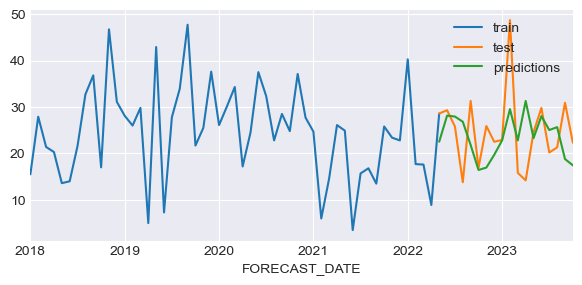

In [97]:
fig, ax = plt.subplots(figsize=(7, 3))
data.loc[:end_train].plot(ax=ax, label='train')
data.loc[end_train:].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend()

In [98]:
data.loc[end_train:].sum(), predictions.sum()

(444.8, 425.01079999999985)

In [99]:
error_mape = mean_absolute_percentage_error(
                y_true = data.loc[end_train:],
                y_pred = predictions
            )
print(f"Test error (mse): {error_mape}")

Test error (mse): 0.29389220066306965


In [100]:
metric, predictions_backtest = backtesting_forecaster(
                                   forecaster            = forecaster,
                                   y                     = data,
                                   steps                 = 17,
                                   metric                = 'mean_absolute_percentage_error',
                                   initial_train_size    = len(data.loc[:end_train]),
                                   fixed_train_size      = False,
                                   gap                   = 0,
                                   allow_incomplete_fold = True,
                                   refit                 = True,
                                   n_jobs                = 'auto',
                                   verbose               = True,
                                   show_progress         = True
                               )

print(f"Backtest error: {metric}")

Information of backtesting process
----------------------------------
Number of observations used for initial training: 53
Number of observations used for backtesting: 17
    Number of folds: 1
    Number of steps per fold: 17
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2018-01-01 00:00:00 -- 2022-05-01 00:00:00  (n=53)
    Validation: 2022-06-01 00:00:00 -- 2023-10-01 00:00:00  (n=17)



100%|██████████| 1/1 [00:00<00:00, 1009.46it/s]

Backtest error: 0.32951342556322477
